In [15]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt

data = pd.read_excel("Australia - EYCI and ESTLI - Daily.xls", usecols="C,D,F", skiprows=7, names=['Date','EYCI','ESTLI']).fillna(method="ffill").dropna().set_index('Date')
data['EYCI-ESTLI'] = data['EYCI'] - data['ESTLI']

print(data.shape)
data.head()

WARNING *** file size (860096) not 512 + multiple of sector size (512)
(9057, 3)


,EYCI,ESTLI,EYCI-ESTLI
Date,,,
1998-01-01,169.5,179.0,-9.5
1998-01-02,169.5,179.0,-9.5
1998-01-03,169.5,179.0,-9.5
1998-01-04,169.5,179.0,-9.5
1998-01-05,169.5,191.0,-21.5


In [16]:
%matplotlib inline

In [17]:
import matplotlib as mpl
mpl.use('agg')

from matplotlib.figure import Figure

def mpl_plot(avg, highlight):
    fig = Figure()
    ax = fig.add_subplot()
    avg.plot(ax=ax, color='black')
    ax.axhline(y=avg.median(), color='gray', linestyle='--', linewidth=0.5)
    if len(highlight): highlight.plot(style='o', ax=ax, ms=3, color='red')
    return fig

def find_outliers(variable='EYCI-ESTLI', window=30, sigma=3, view_fn=mpl_plot):
    avg = data[variable].rolling(window=window).mean()
    residual = data[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = (np.abs(residual) > std * sigma)
    return view_fn(avg, avg[outliers])

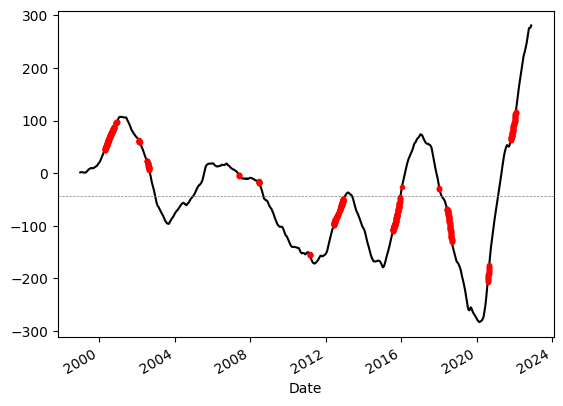

In [18]:
find_outliers(window=364, sigma=3)

In [19]:
import panel as pn
pn.extension()

window = pn.widgets.IntSlider(name='window', value=30, start=1, end=364)
sigma = pn.widgets.IntSlider(name='sigma', value=5, start=0, end=10)

interactive = pn.bind(find_outliers, window=window, sigma=sigma)

Column
    [0] IntSlider(end=364, name='window', start=1, value=30)
    [1] IntSlider(end=10, name='sigma', value=5)
    [2] ParamFunction(function, _pane=Matplotlib)
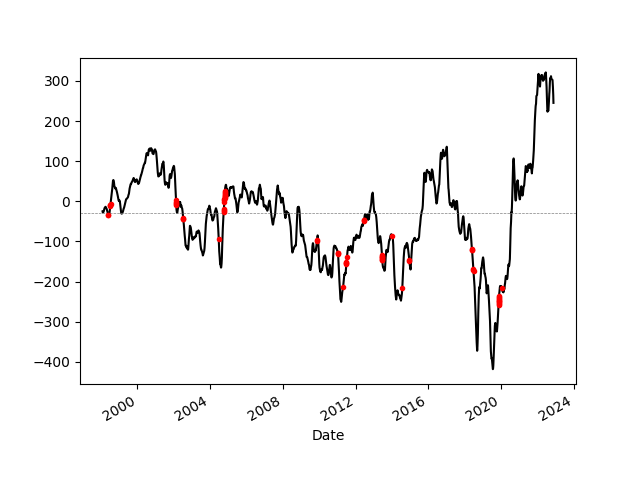

In [20]:
first_app = pn.Column(window, sigma, interactive)

first_app

In [21]:
#first_app.servable();

In [42]:
import param
import hvplot.pandas
import holoviews as hv

def hvplot(avg, highlight):
    hline = hv.HLine(avg.median())
    hline.opts(
        color='gray', 
        line_dash='dashed', 
        line_width=1.0,
    )
    return avg.hvplot(height=200, color='black') * highlight.hvplot.scatter(color='Red', padding=0.1) * hline

class RoomOccupancy(param.Parameterized):
    variable  = param.Selector(objects=list(data.columns))
    window    = param.Integer(default=364, bounds=(1, 364))
    #sigma     = param.Number(default=3, bounds=(0, 10))
    sigma     = param.Integer(default=3, bounds=(0, 10))

    def view(self):
        return find_outliers(self.variable, self.window, self.sigma, view_fn=hvplot)

obj = RoomOccupancy()
obj

RoomOccupancy(name='RoomOccupancy03701', sigma=3, variable='EYCI', window=364)

In [43]:
pn.Row(obj.param, obj.view)

Row
    [0] Column(margin=5, name='RoomOccupancy', width=300)
        [0] StaticText(value='<b>RoomOccupancy</b>')
        [1] Select(name='Variable', options=OrderedDict([('EYCI', ...]), value='EYCI')
        [2] IntSlider(end=364, name='Window', start=1, value=364)
        [3] IntSlider(end=10, name='Sigma', value=3)
    [1] ParamMethod(method, _pane=HoloViews)

In [24]:
pn.Row(obj.param, obj.view).servable();